In [3]:
from PreFRBLE.convenience import *
from PreFRBLE.estimate_redshift import *
from PreFRBLE.plot import *
from PreFRBLE.likelihood import *
from PreFRBLE.physics import *
from PreFRBLE.sample import *

In [4]:
scenario = {
    'IGM' : ['primordial'],
    'Host' : ['Rodrigues18/smd'],
    'Inter' : ['Rodrigues18'],
    'Local' : ['Piro18/wind'],
}

scenario = {
    'IGM' : ['primordial'],
    'Host': ['JF12/StarDensity_MW'],
    'Local': ['Piro18/wind'], 
}

scenario_test = {
    'IGM' : ['primordial'],
    'Host': ['Heesen11/dirty'],
    'Local': ['Piro18/wind'], 
}


scenario0 = {
    'IGM' : ['primordial'],
    'Host': ['JF12/StarDensity_MW'],
    'Local': ['Piro18/wind'], 
}

scenario_IGM = {
    'IGM' : ['primordial'],
}

f_IGMs = np.arange(0.500,0.901, 0.100)
alphas = np.arange(1.,9.1,1.0)/3


In [25]:
RM = np.abs(FRBs['RM'])
RM = RM[RM>0]
RM.min(), RM.max()

/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


(1.5, 220.6)

In [3]:
def GetFRBsMeasures( measure='DM', FRBs=None ):
    if measure == 'DM':
        return FRBs['DM']-FRBs['DM_gal']
    elif measure == 'RM':
        return FRBs['RM']

observed_range = {
    'DM' : (1e1,1e4),
    'RM' : (1e-1,1e3),
    
}
    
    
def LikelihoodObservedMeasure( measure='DM', scenario={}, telescope='Parkes', population='SMD', FRBs=None, Measures=None, use_localized=True, plot=False, plot_FRBs=False, ax=None, label=None, title=None, force=False ):
    """ 
    returns likelihood of values of DM observed by telescope for the case of scenario and population
    
    Parameters
    ----------
    FRBs : array-like
        list of FRBs observed by telescope, result of GetFRBcat( telescopes=[telescope] )
    
    Returns
    -------
    likelihoods : array-like
        1D array with likelihoods of individual DM observed by telescope  
    """

    P_M, M = GetLikelihood_Telescope( measure=measure, telescope=telescope, population=population, force=force, **scenario )
        
    if Measures is None:
        ## read observed values of extragalactic DM
        if FRBs is None:
            FRBs = GetFRBcat( telescopes=[telescope] )
        Measures = GetFRBsMeasures( measure=measure, FRBs=FRBs )
    if plot:
        if ax is None:
            fig, ax = plt.subplots()
        if title is None:
            title = "%s with %s" % (population, telescope)
        ax.set_title( title )
        PlotLikelihood( P=P_M, x=M, measure=measure, label=label, ax=ax )
        
        if plot_FRBs:
            P_, x_ = Histogram( data=np.abs(Measures), bins=10, log=True, density=True, range=observed_range[measure] )#, range=(1e1,1e4) )
            PlotLikelihood( P=P_, x=x_, measure=measure, ax=ax, label="observed", linestyle='-.', color='black' )
#        AllSidesTicks( ax )
    
    ## compute likelihood of observation
    likelihoods = Likelihoods( measurements=Measures, P=P_M, x=M )
    
    ## for FRBs with localized host, use likelihood for DM from that redshift, P(DM|z_host), instead
    if use_localized:
        localized, = np.where( FRBs['host_redshift']>0 )
        for loc in localized:
            z_host = np.round(FRBs[loc]['host_redshift'],1)
            
            P_z, z = GetLikelihood_Redshift( population=population, telescope=telescope )
            P_M, M = GetLikelihood_Full( measure=measure, redshift=z_host, force=force, **scenario )
            
            ## likelihood for host redshift in population 
            prior = Likelihoods( measurements=[z_host], P=P_z, x=z ) ##**( 1 - (telescope in ['ASKAP']) )  ## ignore redhift prior for these telescope, since they are not informative for population
            ## multiply by likelihood for DM at host redshift
            likelihoods[loc], = Likelihoods( measurements=[Measures[loc]], P=P_M, x=M ) * prior 

        if plot_FRBs:
            y_Measures = 0.75-0.5*np.random.rand( len(localized) )
            ax.plot( Measures[localized], y_Measures, marker='x', linestyle=' ' )
    return likelihoods


{'IGM': ['alpha1-3rd_C300'], 'Host': ['Heesen11/dirty'], 'Local': ['Piro18/wind']}
{'IGM': ['alpha1-3rd_C900'], 'Host': ['Heesen11/dirty'], 'Local': ['Piro18/wind']}


/data/PreFRBLE/venv_PreFRBLE/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/data/PreFRBLE/venv_PreFRBLE/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


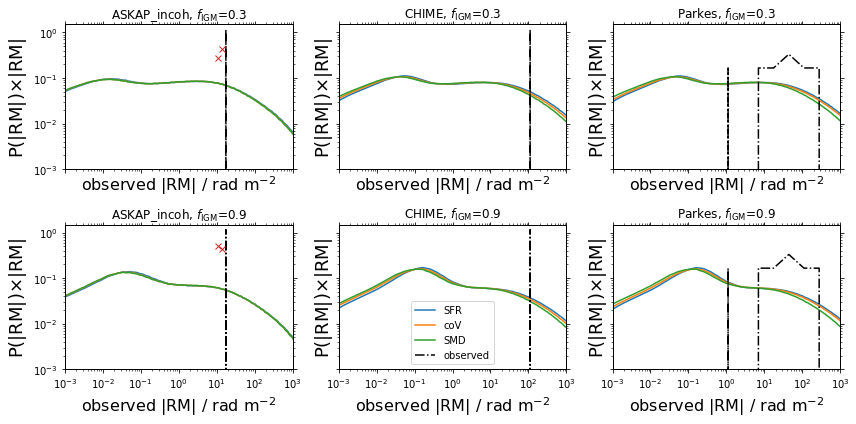

  0%|          | 0/60 [00:00<?, ?it/s]

{'IGM': ['alpha9-3rd_C300'], 'Host': ['Heesen11/dirty'], 'Local': ['Piro18/wind']}


  0%|          | 0/60 [00:00<?, ?it/s]

{'IGM': ['alpha9-3rd_C900'], 'Host': ['Heesen11/dirty'], 'Local': ['Piro18/wind']}


100%|██████████| 60/60 [00:00<00:00, 1170.47it/s]


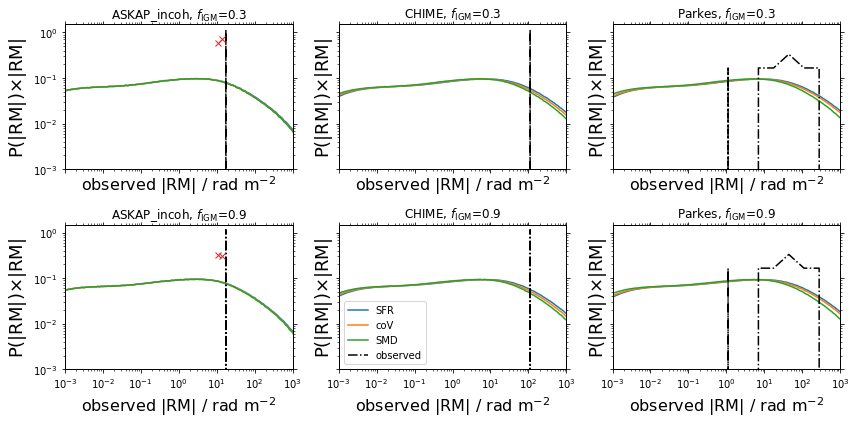

In [4]:
#fig, axss = plt.subplots( 2, 3, figsize=(12,6), sharex=True, sharey=True)
for alpha in [1, 9]:
    fig, axss = plt.subplots( 2, 3, figsize=(12,6), sharex=True, sharey=True)
    for f_IGM, axs in zip( f_IGMs[np.array([0,-1])], axss ):
        tmp = scenario_test.copy()
        tmp['IGM'] = ['alpha%i-3rd_C%.0f' % (alpha, f_IGM*1000)]
        print(tmp)
        for telescope, ax in zip( telescopes, axs):
#            ax.set_xlim(1e-3,1e3)
            ax.set_ylim(1e-3,1.5)
            #ax.set_ylim(1e-5,1.5)
            ax.set_title( r"%s, $f_{\rm IGM}$=%.1f" % (telescope, f_IGM) )
            for population in populations:
#                P, x = GetLikelihood_Telescope( measure='RM', telescope=telescope, population=population, force=False, **tmp )
#                PlotLikelihood( P=P, x=x,label=population, ax=ax )
                LikelihoodObservedMeasure( force=False, measure='RM', scenario=tmp, telescope=telescope, population=population, plot=True, ax=ax, plot_FRBs=population == populations[-1], label=population, title=r"%s, $f_{\rm IGM}$=%.1f" % (telescope, f_IGM) )
            AllSidesTicks(ax)
    axss[1][1].legend()
    fig.tight_layout()
    plt.show()
#axss[1][1].legend()
#fig.tight_layout()
#plt.show()

{'IGM': ['alpha1-3rd_C300']}
{'IGM': ['alpha1-3rd_C900']}
{'IGM': ['alpha9-3rd_C300']}
{'IGM': ['alpha9-3rd_C900']}


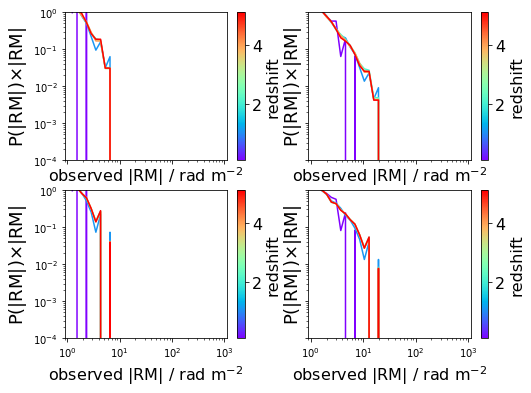

In [10]:
#fig, axss = plt.subplots( len(alphas), len(f_IGMs), figsize=(len(f_IGMs)*4, len(models_IGM[3:])*3), sharex=True, sharey=True )
fig, axss = plt.subplots( 2, 2, figsize=(8,6), sharex=True, sharey=True )
#for i_a, model in enumerate( np.array(models_IGM[3:])[np.array([0,-1])] ):
for i_a, alpha in enumerate( alphas[np.array([0,-1])] ):
    for i_f, f_IGM in enumerate( np.array(f_IGMs)[np.array([0,-1])] ):
        tmp = scenario_IGM.copy()
        tmp['IGM'] = ['alpha%i-3rd_C%.0f' % (int(alpha*3), f_IGM*1000)]
        print(tmp)
        ax = axss[i_a][i_f]
        PlotLikelihoodEvolution( measure='RM', measureable=True, ax=ax, scenario=tmp, redshift_bins=redshift_bins[::10] )
        ax.set_ylim(1e-4,1)

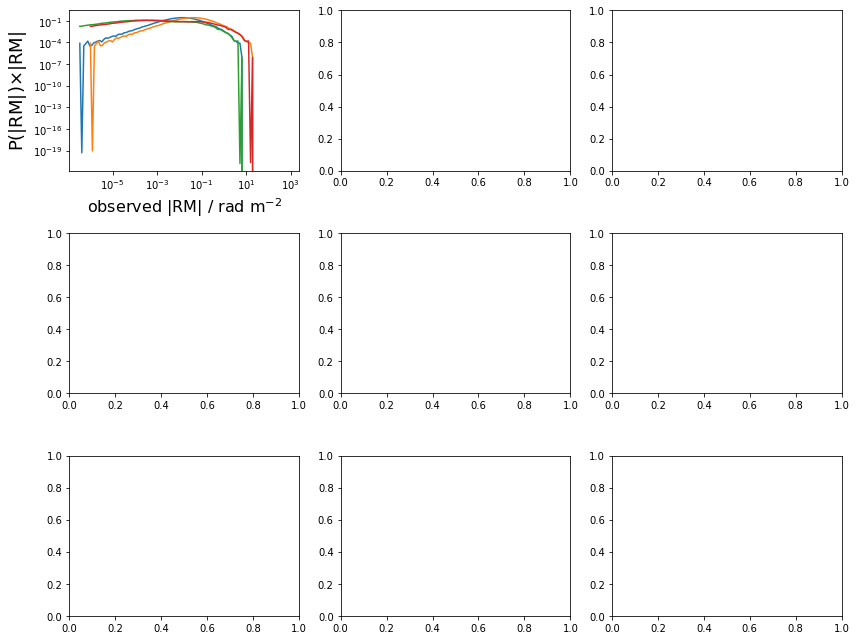

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [6]:

fig, axs = plt.subplots( len(telescopes), len(populations), figsize=(len(populations)*4, 3*len(telescopes)))


for i_t, telescope in enumerate(telescopes):
    for i_p, population in enumerate(populations):
        for i_a, alpha in enumerate( alphas[np.array([0,-1])] ):
            for i_f, f_IGM in enumerate( np.array(f_IGMs)[np.array([0,-1])] ):
                tmp = scenario_IGM.copy()
                tmp['IGM'] = ['alpha%i-3rd_C%.0f' % (int(alpha*3), f_IGM*1000)]
                PlotTelescope( measure='RM', telescope=telescope, population=population, ax=axs[i_p][i_t], label=r"$\alpha$ = %.0f/3, $f_{rm IGM}$ = %.1f" % (alpha*3,f_IGM), scenario=tmp)
        ax.set_ylim(1e-4,1)
        ax.legend()
        plt.show()

In [13]:
FRBs = GetFRBcat(telescopes=['ASKAP'])
FRBs[FRBs['host_redshift']>0]

array([('FRB181112', 589.27, 102. , 10.9, nan, 0.4755, 'ASKAP'),
       ('FRB180924', 361.42,  40.5, 14. , nan, 0.3214, 'ASKAP')],
      dtype=[('ID', '<U9'), ('DM', '<f4'), ('DM_gal', '<f4'), ('RM', '<f4'), ('tau', '<f4'), ('host_redshift', '<f4'), ('tele', '<U10')])

perform joint analysis using a mock sample of FRBs

In [5]:
N = 50 # number of FRBs

bayes_mock = np.zeros( [ len(populations), len(models_IGM[3:]), len(f_IGMs) ] )
population = 'SMD'
telescope = 'Parkes'


scenario_ref = scenario_test.copy()
scenario_ref['IGM'] = ['alpha3-3rd_C700']

print( scenario_ref)

FRBs_mock = FakeFRBs( measures=['DM','RM'], N=50, telescope=telescope, population=population, measureable=True, **scenario_test )# **scenario0 )
DMs = FRBs_mock['DM']
RMs = FRBs_mock['RM']
zs = FRBs_mock['redshift']

L0 = LikelihoodCombined( DMs=DMs, RMs=RMs, scenario=scenario_test, telescope=telescope, population=population )
for i_p, population in enumerate( populations ):
    for i_a, model in enumerate( models_IGM[3:] ):
        for i_f, f_IGM in enumerate( f_IGMs ):
            tmp = scenario_ref.copy()
            tmp['IGM'] = [ "%s_C%.0f" % ( model, f_IGM*1000 ) ]
            print(tmp)
            bayes_mock[i_p,i_a,i_f] = BayesFactorCombined( DMs=DMs, RMs=RMs, scenario1=tmp, scenario2=scenario0, population=population, telescope=telescope)
        
    

{'IGM': ['alpha3-3rd_C700'], 'Host': ['Heesen11/dirty'], 'Local': ['Piro18/wind']}
['primordial/Heesen11/dirty/Piro18/wind/0.1/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/0.1/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/0.1/RM/P', 'primordial/Heesen11/dirty/Piro18/wind/0.1/RM/x']
['primordial/Heesen11/dirty/Piro18/wind/0.2/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/0.2/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/0.2/RM/P', 'primordial/Heesen11/dirty/Piro18/wind/0.2/RM/x']
['primordial/Heesen11/dirty/Piro18/wind/0.3/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/0.3/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/0.3/RM/P', 'primordial/Heesen11/dirty/Piro18/wind/0.3/RM/x']
['primordial/Heesen11/dirty/Piro18/wind/0.4/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/0.4/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/0.4/RM/P', 'primordial/Heesen11/dirty/Piro18/wind/0.4/RM/x']
['primordial/Heesen11/dirty/Piro18/wind/0.5/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/0.5/DM/x']
['primor

['primordial/Heesen11/dirty/Piro18/wind/6.0/RM/P', 'primordial/Heesen11/dirty/Piro18/wind/6.0/RM/x']
['primordial/Heesen11/dirty/Piro18/wind/0.1/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/0.1/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/0.2/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/0.2/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/0.3/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/0.3/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/0.4/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/0.4/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/0.5/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/0.5/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/0.6/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/0.6/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/0.7/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/0.7/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/0.8/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/0.8/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/0.9/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/0

['primordial/Heesen11/dirty/Piro18/wind/4.3/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/4.3/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/4.4/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/4.4/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/4.5/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/4.5/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/4.6/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/4.6/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/4.7/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/4.7/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/4.8/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/4.8/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/4.9/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/4.9/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/5.0/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/5.0/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/5.1/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/5.1/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/5.2/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/5

['primordial/JF12/StarDensity_MW/Piro18/wind/2.0/RM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/2.0/RM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/2.1/RM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/2.1/RM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/2.2/RM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/2.2/RM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/2.3/RM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/2.3/RM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/2.4/RM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/2.4/RM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/2.5/RM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/2.5/RM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/2.6/RM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/2.6/RM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/2.7/RM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/2.7/RM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/2.8/RM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/2.8/RM/x']
[

['alpha1-3rd_C600/Heesen11/dirty/Piro18/wind/5.7/RM/P', 'alpha1-3rd_C600/Heesen11/dirty/Piro18/wind/5.7/RM/x']
['alpha1-3rd_C600/Heesen11/dirty/Piro18/wind/5.8/RM/P', 'alpha1-3rd_C600/Heesen11/dirty/Piro18/wind/5.8/RM/x']
['alpha1-3rd_C600/Heesen11/dirty/Piro18/wind/5.9/RM/P', 'alpha1-3rd_C600/Heesen11/dirty/Piro18/wind/5.9/RM/x']
['alpha1-3rd_C600/Heesen11/dirty/Piro18/wind/6.0/RM/P', 'alpha1-3rd_C600/Heesen11/dirty/Piro18/wind/6.0/RM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/0.1/DM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/0.1/DM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/0.2/DM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/0.2/DM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/0.3/DM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/0.3/DM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/0.4/DM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/0.4/DM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/0.5/DM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/0.5/DM/x']
[

['primordial/Heesen11/dirty/Piro18/wind/1.9/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/1.9/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/2.0/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/2.0/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/2.1/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/2.1/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/2.2/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/2.2/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/2.3/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/2.3/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/2.4/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/2.4/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/2.5/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/2.5/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/2.6/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/2.6/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/2.7/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/2.7/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/2.8/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/2

['primordial/JF12/StarDensity_MW/Piro18/wind/2.6/DM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/2.6/DM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/2.7/DM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/2.7/DM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/2.8/DM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/2.8/DM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/2.9/DM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/2.9/DM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/3.0/DM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/3.0/DM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/3.1/DM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/3.1/DM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/3.2/DM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/3.2/DM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/3.3/DM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/3.3/DM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/3.4/DM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/3.4/DM/x']
[

['primordial/Heesen11/dirty/Piro18/wind/4.8/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/4.8/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/4.9/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/4.9/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/5.0/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/5.0/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/5.1/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/5.1/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/5.2/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/5.2/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/5.3/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/5.3/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/5.4/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/5.4/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/5.5/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/5.5/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/5.6/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/5.6/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/5.7/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/5

['primordial/JF12/StarDensity_MW/Piro18/wind/1.4/RM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/1.4/RM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/1.5/RM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/1.5/RM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/1.6/RM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/1.6/RM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/1.7/RM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/1.7/RM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/1.8/RM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/1.8/RM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/1.9/RM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/1.9/RM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/2.0/RM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/2.0/RM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/2.1/RM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/2.1/RM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/2.2/RM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/2.2/RM/x']
[

['alpha1-3rd_C900/Heesen11/dirty/Piro18/wind/0.5/RM/P', 'alpha1-3rd_C900/Heesen11/dirty/Piro18/wind/0.5/RM/x']
['alpha1-3rd_C900/Heesen11/dirty/Piro18/wind/0.6/RM/P', 'alpha1-3rd_C900/Heesen11/dirty/Piro18/wind/0.6/RM/x']
['alpha1-3rd_C900/Heesen11/dirty/Piro18/wind/0.7/RM/P', 'alpha1-3rd_C900/Heesen11/dirty/Piro18/wind/0.7/RM/x']
['alpha1-3rd_C900/Heesen11/dirty/Piro18/wind/0.8/RM/P', 'alpha1-3rd_C900/Heesen11/dirty/Piro18/wind/0.8/RM/x']
['alpha1-3rd_C900/Heesen11/dirty/Piro18/wind/0.9/RM/P', 'alpha1-3rd_C900/Heesen11/dirty/Piro18/wind/0.9/RM/x']
['alpha1-3rd_C900/Heesen11/dirty/Piro18/wind/1.0/RM/P', 'alpha1-3rd_C900/Heesen11/dirty/Piro18/wind/1.0/RM/x']
['alpha1-3rd_C900/Heesen11/dirty/Piro18/wind/1.1/RM/P', 'alpha1-3rd_C900/Heesen11/dirty/Piro18/wind/1.1/RM/x']
['alpha1-3rd_C900/Heesen11/dirty/Piro18/wind/1.2/RM/P', 'alpha1-3rd_C900/Heesen11/dirty/Piro18/wind/1.2/RM/x']
['alpha1-3rd_C900/Heesen11/dirty/Piro18/wind/1.3/RM/P', 'alpha1-3rd_C900/Heesen11/dirty/Piro18/wind/1.3/RM/x']
[

['primordial/JF12/StarDensity_MW/Piro18/wind/2.4/DM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/2.4/DM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/2.5/DM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/2.5/DM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/2.6/DM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/2.6/DM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/2.7/DM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/2.7/DM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/2.8/DM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/2.8/DM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/2.9/DM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/2.9/DM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/3.0/DM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/3.0/DM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/3.1/DM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/3.1/DM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/3.2/DM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/3.2/DM/x']
[

['primordial/Heesen11/dirty/Piro18/wind/5.2/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/5.2/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/5.3/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/5.3/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/5.4/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/5.4/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/5.5/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/5.5/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/5.6/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/5.6/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/5.7/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/5.7/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/5.8/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/5.8/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/5.9/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/5.9/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/6.0/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/6.0/DM/x']
['alpha2-3rd_C500/Heesen11/dirty/Piro18/wind/0.1/RM/P', 'alpha2-3rd_C500/Heesen11/dirty/Pir

['primordial/JF12/StarDensity_MW/Piro18/wind/1.8/DM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/1.8/DM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/1.9/DM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/1.9/DM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/2.0/DM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/2.0/DM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/2.1/DM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/2.1/DM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/2.2/DM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/2.2/DM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/2.3/DM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/2.3/DM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/2.4/DM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/2.4/DM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/2.5/DM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/2.5/DM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/2.6/DM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/2.6/DM/x']
[

['primordial/JF12/StarDensity_MW/Piro18/wind/5.6/RM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/5.6/RM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/5.7/RM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/5.7/RM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/5.8/RM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/5.8/RM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/5.9/RM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/5.9/RM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/6.0/RM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/6.0/RM/x']
{'IGM': ['alpha2-3rd_C600'], 'Host': ['Heesen11/dirty'], 'Local': ['Piro18/wind']}
['primordial/Heesen11/dirty/Piro18/wind/0.1/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/0.1/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/0.2/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/0.2/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/0.3/DM/P', 'primordial/Heesen11/dirty/Piro18/wind/0.3/DM/x']
['primordial/Heesen11/dirty/Piro18/wind/0.4/DM/P', 'primord

['alpha2-3rd_C600/Heesen11/dirty/Piro18/wind/1.7/RM/P', 'alpha2-3rd_C600/Heesen11/dirty/Piro18/wind/1.7/RM/x']
['alpha2-3rd_C600/Heesen11/dirty/Piro18/wind/1.8/RM/P', 'alpha2-3rd_C600/Heesen11/dirty/Piro18/wind/1.8/RM/x']
['alpha2-3rd_C600/Heesen11/dirty/Piro18/wind/1.9/RM/P', 'alpha2-3rd_C600/Heesen11/dirty/Piro18/wind/1.9/RM/x']
['alpha2-3rd_C600/Heesen11/dirty/Piro18/wind/2.0/RM/P', 'alpha2-3rd_C600/Heesen11/dirty/Piro18/wind/2.0/RM/x']
['alpha2-3rd_C600/Heesen11/dirty/Piro18/wind/2.1/RM/P', 'alpha2-3rd_C600/Heesen11/dirty/Piro18/wind/2.1/RM/x']
['alpha2-3rd_C600/Heesen11/dirty/Piro18/wind/2.2/RM/P', 'alpha2-3rd_C600/Heesen11/dirty/Piro18/wind/2.2/RM/x']
['alpha2-3rd_C600/Heesen11/dirty/Piro18/wind/2.3/RM/P', 'alpha2-3rd_C600/Heesen11/dirty/Piro18/wind/2.3/RM/x']
['alpha2-3rd_C600/Heesen11/dirty/Piro18/wind/2.4/RM/P', 'alpha2-3rd_C600/Heesen11/dirty/Piro18/wind/2.4/RM/x']
['alpha2-3rd_C600/Heesen11/dirty/Piro18/wind/2.5/RM/P', 'alpha2-3rd_C600/Heesen11/dirty/Piro18/wind/2.5/RM/x']
[

['primordial/JF12/StarDensity_MW/Piro18/wind/0.7/RM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/0.7/RM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/0.8/RM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/0.8/RM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/0.9/RM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/0.9/RM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/1.0/RM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/1.0/RM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/1.1/RM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/1.1/RM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/1.2/RM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/1.2/RM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/1.3/RM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/1.3/RM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/1.4/RM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/1.4/RM/x']
['primordial/JF12/StarDensity_MW/Piro18/wind/1.5/RM/P', 'primordial/JF12/StarDensity_MW/Piro18/wind/1.5/RM/x']
[

['alpha2-3rd_C700/Heesen11/dirty/Piro18/wind/2.7/RM/P', 'alpha2-3rd_C700/Heesen11/dirty/Piro18/wind/2.7/RM/x']
['alpha2-3rd_C700/Heesen11/dirty/Piro18/wind/2.8/RM/P', 'alpha2-3rd_C700/Heesen11/dirty/Piro18/wind/2.8/RM/x']
['alpha2-3rd_C700/Heesen11/dirty/Piro18/wind/2.9/RM/P', 'alpha2-3rd_C700/Heesen11/dirty/Piro18/wind/2.9/RM/x']
['alpha2-3rd_C700/Heesen11/dirty/Piro18/wind/3.0/RM/P', 'alpha2-3rd_C700/Heesen11/dirty/Piro18/wind/3.0/RM/x']
['alpha2-3rd_C700/Heesen11/dirty/Piro18/wind/3.1/RM/P', 'alpha2-3rd_C700/Heesen11/dirty/Piro18/wind/3.1/RM/x']
['alpha2-3rd_C700/Heesen11/dirty/Piro18/wind/3.2/RM/P', 'alpha2-3rd_C700/Heesen11/dirty/Piro18/wind/3.2/RM/x']


KeyboardInterrupt: 

In [ ]:
bayes_mock
#LikelihoodObservedMeasure( Measures=RMs, measure='RM', scenario={'IGM':['alpha1-3rd_C900']}, telescope=telescope, population=population, plot=True, plot_FRBs=True, title=r"CHIME mock sample", use_localized=False )


In [ ]:
for i_b, b in enumerate( bayes_mock ):
    fig, ax = plt.subplots()
    PlotBayes2D( bayes=b, y=alphas, x=f_IGMs, ylabel=r"$\alpha$", xlabel=r"$f_{\rm IGM}$", ax=ax, plane=True )
    ax.set_title( 'mock CHIME results, N=%i, %s' % (N, populations[i_b]) )
    plt.show()

perform joint analysis using events in FRBcat

In [13]:
bayes = np.zeros( [ len(populations), len(telescopes), len(models_IGM[3:]), len(f_IGMs) ] )

#for i_p, population in enumerate( populations ):
for i_p in trange( len(populations) ):
    population = populations[i_p]
    for i_t, telescope in enumerate( telescopes ):
        FRBs = GetFRBcat( telescopes=[telescope] )
        DMs = GetFRBsMeasures( measure='DM', FRBs=FRBs)
        RMs = GetFRBsMeasures( measure='RM', FRBs=FRBs)
        L0 = LikelihoodCombined( DMs=DMs, RMs=RMs, scenario=scenario0, telescope=telescope, population=population )
        for i_a, model in enumerate( models_IGM[3:] ):
            for i_f, f_IGM in enumerate( f_IGMs ):
                tmp = scenario_test.copy()
                tmp['IGM'] = [ "%s_C%.0f" % ( model, f_IGM*1000 ) ]
                print(tmp)
                bayes[i_p,i_t,i_a,i_f] = BayesFactorCombined( DMs=DMs, RMs=RMs, scenario1=tmp, scenario2=scenario0, population=population, telescope=telescope)
        
    

  0%|          | 0/3 [00:00<?, ?it/s]

{'IGM': ['alpha1-3rd_C500'], 'Host': ['Heesen11/dirty'], 'Local': ['Piro18/wind']}
{'IGM': ['alpha1-3rd_C600'], 'Host': ['Heesen11/dirty'], 'Local': ['Piro18/wind']}
{'IGM': ['alpha1-3rd_C700'], 'Host': ['Heesen11/dirty'], 'Local': ['Piro18/wind']}
{'IGM': ['alpha1-3rd_C800'], 'Host': ['Heesen11/dirty'], 'Local': ['Piro18/wind']}
{'IGM': ['alpha1-3rd_C900'], 'Host': ['Heesen11/dirty'], 'Local': ['Piro18/wind']}
{'IGM': ['alpha2-3rd_C500'], 'Host': ['Heesen11/dirty'], 'Local': ['Piro18/wind']}
{'IGM': ['alpha2-3rd_C600'], 'Host': ['Heesen11/dirty'], 'Local': ['Piro18/wind']}
{'IGM': ['alpha2-3rd_C700'], 'Host': ['Heesen11/dirty'], 'Local': ['Piro18/wind']}


KeyboardInterrupt: 

In [ ]:

fig, axss = plt.subplots( len(populations)+1, len(telescopes), figsize=(4*len(telescopes), 3*(1+len(populations)) ) )
for i_p, (population, axs) in enumerate( zip(populations, axss) ):
    for i_t, (telescope, ax) in enumerate( zip( telescopes, axs) ):
        PlotBayes2D( bayes=bayes[i_p,i_t], y=alphas, x=f_IGMs, ylabel=r"$\alpha$", xlabel=r"$f_{\rm IGM}$", ax=ax, plane=True )
        ax.set_title( '%s with %s' % (population, telescope))

b = np.prod( bayes, axis=1 )
for i_p, (population, ax) in enumerate( zip(populations, axss[-1]) ):
    PlotBayes2D( bayes=b[i_p], y=alphas, x=f_IGMs, ylabel=r"$\alpha$", xlabel=r"$f_{\rm IGM}$", ax=ax, plane=True )
    ax.set_title( '%s combined' % population)
    
                        

In [8]:
FRBs = GetFRBcat(telescopes=telescopes)

In [10]:
FRBs[np.abs(FRBs['RM'])>0]

/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


array([('FRB181112',  589.27, 102. ,   10.9,  nan, 0.4755, 'ASKAP'),
       ('FRB180924',  361.42,  40.5,   14. ,  nan, 0.3214, 'ASKAP'),
       ('FRB180916',  349.2 , 200. , -114.6,  nan,    nan, 'CHIME/FRB'),
       ('FRB180714', 1467.92, 257. ,  -25.9,  nan,    nan, 'parkes'),
       ('FRB180311', 1570.9 ,  45.2,    4.8,  nan,    nan, 'parkes'),
       ('FRB171209', 1457.4 ,  13. ,  121.6, 0.66,    nan, 'parkes'),
       ('FRB160102', 2596.1 ,  13. , -220.6, 4.  ,    nan, 'parkes'),
       ('FRB150807',  266.5 ,  36.9,   12. ,  nan,    nan, 'parkes'),
       ('FRB150418',  776.2 , 188.5,   36. ,  nan,    nan, 'parkes'),
       ('FRB150215', 1105.6 , 427.2,    1.5,  nan,    nan, 'parkes')],
      dtype=[('ID', '<U9'), ('DM', '<f4'), ('DM_gal', '<f4'), ('RM', '<f4'), ('tau', '<f4'), ('host_redshift', '<f4'), ('tele', '<U10')])